# Cerinta 1 - Reprezentarea modelului de clasificare

In [1]:
from json import dumps
from math import inf, log
import matplotlib.pyplot as plt
from operator import add
from os import listdir
from os.path import basename
from random import shuffle
from regex import sub
from rouge_score import rouge_scorer
from statistics import mean, stdev

from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

download('wordnet')
download('punkt')
download('stopwords')

[nltk_data] Downloading package wordnet to /home/teo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/teo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/teo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class NewsSummarisationModel:
    def __init__(self, stop_words_file, elim_stops, lemmatise, n_grams):
        self._ALPHA = 1
        self._chars_to_remove = ',-~`|\\/:;\'"?![]()#^&*@$\n\"'
        self.elim_stops = elim_stops
        self.lemmatise = lemmatise
        self.n_grams = n_grams

        self.class_app = {
            True: 0,
            False: 0
        }
        self.class_words = {
            True: {},
            False: {}
        }
        self.total_words = {
            True: 0,
            False: 0
        }
        self.total_sents = 0
        self.voc = set()

        self.wnl = WordNetLemmatizer()

        self.stop_words = set(stopwords.words('english')) | set(' ')
        with open(stop_words_file) as f:
            self.stop_words.union(set(token.replace('\n', '') for token in f))


    def _remove_chars(self, s):
        for ch in self._chars_to_remove:
            s = s.replace(ch, '')
        return s


    def _should_keep_token(self, tok):
        return tok not in self.stop_words if self.elim_stops else True


    def group_n_grams(self, words):
        return ['|'.join(words[i : i + self.n_grams])
            for i in range(len(words) - self.n_grams + 1)]


    def parse_sents(self, sents):
        lems = []
        for sent in sents:
            for tok in word_tokenize(sent):
                if self._should_keep_token(tok):
                    if self.lemmatise:
                        lem = self.wnl.lemmatize(self._remove_chars(tok).lower())
                    else:
                        lem = tok

                    if lem and \
                        not self.elim_stops or lem not in self.stop_words:
                        lems.append(lem)

        return self.group_n_grams(lems)


    def _add_lems_to_class(self, lems, cl):
        for lem in lems:
            self.voc.add(lem)

            if lem in self.class_words[cl]:
                self.class_words[cl][lem] += 1
            else:
                self.class_words[cl][lem] = 1


    def add_file_summary(self, file, summ):
        with open(summ) as f:
            summ_str = f.read()
        with open(file) as f:
            file_sent = sent_tokenize(sub(r'[\.?!]+([A-Z])', r'. \1', f.read()))
            self.total_sents += len(file_sent)

        file_sent_keep = list(filter(lambda s: s in summ_str, file_sent))
        self.class_app[True] += len(file_sent_keep)

        summ_lems = self.parse_sents(file_sent_keep)
        self.total_words[True] += len(summ_lems)
        self._add_lems_to_class(summ_lems, True)

        file_sent_drop = list(filter(lambda s: s not in summ_str, file_sent))
        self.class_app[False] += len(file_sent_drop)

        drop_lems = self.parse_sents(file_sent_drop)
        self.total_words[False] += len(drop_lems)
        self._add_lems_to_class(drop_lems, False)


    def _compute_log_prob(self, word, cl):
        return log(
            (self.class_words[cl].get(word, 0) + self._ALPHA)
            / (self.total_words[cl] + len(self.voc) * self._ALPHA)
        )


    def _make_pred(self, sent):
        lems = self.parse_sents([sent])
        max_prob = -inf

        for cl in self.class_words:
            cl_prob = sum(
                map(lambda l: self._compute_log_prob(l, cl), lems),
                log(self.class_app[cl] / self.total_sents)
            )

            if max_prob <= cl_prob:
                max_prob = cl_prob
                pred = cl

        return pred, max_prob


    def run_inference(self, file):
        with open(file) as f:
            sents = sent_tokenize(sub(r'[\.?!]+([A-Z])', r'. \1', f.read()))
        keeps = list(map(lambda s: self._make_pred(s), sents))
        predicted_sents = zip(sents, keeps)

        for pred, _ in keeps:
            if pred:
                return [sent for sent, keep in predicted_sents if keep[0]]

        predicted_sents = list(predicted_sents)
        predicted_sents.sort(key=lambda p: p[1][1])
        return [predicted_sents[0][0]]

In [3]:
def _get_files_summ(path):
    files = []
    for clss in listdir(f'{path}/News Articles'):
        files += list(map(
            lambda f: (
                f'{path}/News Articles/{clss}/{f}',
                f'{path}/Summaries/{clss}/{f}',
            ),
            listdir(f'{path}/News Articles/{clss}')
        ))

    shuffle(files)
    return files


def _get_train_test_files(path):
    files = _get_files_summ(path)
    num_files = len(files)
    num_tests = int(num_files / 4)

    test_files = files[:num_tests]
    train_files = files[num_tests:]

    return train_files, test_files, listdir(path)


def _run_tests(model, scorer, test_files, n_grams):
    recalls = {'rouge1': [], 'rouge2': []}
    precs = {'rouge1': [], 'rouge2': []}

    for file, summ in test_files:
        with open(summ) as f:
            true_summ = f.read()
        pred_summ = ' '.join(model.run_inference(file))
        scores = scorer.score(true_summ, pred_summ)

        for metric in recalls:
            recalls[metric].append(scores[metric].recall)
            precs[metric].append(scores[metric].precision)

    prec = {
        'rouge1': mean(precs['rouge1']),
        'rouge2': mean(precs['rouge2'])
    }
    rec = {
        'rouge1': mean(recalls['rouge1']),
        'rouge2': mean(recalls['rouge2'])
    }
    return rec, prec


def _display_results(xs, precs, recalls, elim_stops, lemmatise, n_grams):
    plt.figure(figsize=(23,5))
    plt.plot(xs, precs['rouge1'], label='Precizie ROUGE-1')
    plt.plot(xs, recalls['rouge1'], label='Regasire ROUGE-1')
    plt.plot(xs, precs['rouge2'], label='Precizie ROUGE-2')
    plt.plot(xs, recalls['rouge2'], label='Regasire ROUGE-2')
    
    plt.xlabel('Fisierele de antrenament', fontsize=20)
    plt.ylabel('Procentaj', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.legend(fontsize=20)

    lem = 'cu' if lemmatise else 'fara'
    elim = 'cu' if elim_stops else 'fara'
    n_grams_str = 'monograme' if n_grams == 1 else 'bigrame'
    plt.title(
        f'Scoruri ROUGE, cu {n_grams_str}, {lem} lematizare si {elim} eliminarea cuvintelor neinformative',
        fontsize=20
    )

    plt.grid()
    plt.show()
    
    print(f'Precizia ROUGE-1 cu {n_grams_str}, {lem} lematizare si {elim} eliminare: {precs["rouge1"][len(precs["rouge1"]) - 1]}')
    print(f'Regasirea ROUGE-1 cu {n_grams_str}, {lem} lematizare si {elim} eliminare: {recalls["rouge1"][len(recalls["rouge2"]) - 1]}')
    print(f'Precizia ROUGE-2 cu {n_grams_str}, {lem} lematizare si {elim} eliminare: {precs["rouge2"][len(precs["rouge2"]) - 1]}')
    print(f'Regasirea ROUGE-2 cu {n_grams_str}, {lem} lematizare si {elim} eliminare: {recalls["rouge2"][len(recalls["rouge2"]) - 1]}')


def train_and_test(path, stop_words_file, elim_stops, lemmatise, n_grams):
    model = NewsSummarisationModel(stop_words_file, elim_stops, lemmatise, n_grams)
    train_files, test_files, classes = _get_train_test_files(path)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], lemmatise)

    precs = {'rouge1': [], 'rouge2': []}
    recalls = {'rouge1': [], 'rouge2': []}
    xs = []
    i = 1

    for file, summ in train_files:
        if i % 100 == 0:
            xs.append(i)
            rec, prec = _run_tests(model, scorer, test_files, n_grams)
            for metric in precs:
                precs[metric].append(prec[metric])
                recalls[metric].append(rec[metric])

        model.add_file_summary(file, summ)
        i += 1

    xs.append(i)
    rec, prec = _run_tests(model, scorer, test_files, n_grams)
    for metric in precs:
        precs[metric].append(prec[metric])
        recalls[metric].append(rec[metric])

    _display_results(xs, precs, recalls, elim_stops, lemmatise, n_grams)


def _get_file_groups(path, num_groups):
    files = _get_files_summ(path)

    num_files = len(files)
    chunk_size = int(num_files / num_groups)

    file_groups = [files[i*chunk_size : (i+1)*chunk_size]
        for i in range(num_groups)]

    return file_groups


def train_test_cross_validate(
    path,
    stop_words_file,
    elim_stops,
    lemmatise,
    n_grams,
    num_groups
):
    file_groups = _get_file_groups(path, num_groups)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], lemmatise)

    results = {
        'rouge1': {
            'precision': {},
            'recall': {}
        },
        'rouge2': {
            'precision': {},
            'recall': {}
        }
    }
    precs = {'rouge1': [], 'rouge2': []}
    recalls = {'rouge1': [], 'rouge2': []}

    for i in range(len(file_groups)):
        test_files = file_groups[i]
        train_groups = file_groups[:i] + file_groups[i+1:]
        train_files = sum(train_groups, [])

        model = NewsSummarisationModel(stop_words_file, elim_stops, lemmatise, n_grams)
        [model.add_file_summary(file, summ) for file, summ in train_files]

        rec, prec = _run_tests(model, scorer, test_files, n_grams)
        for metric in precs:
            precs[metric].append(prec[metric])
            recalls[metric].append(rec[metric])

    for metric in results:
        results[metric]['precision']['mean'] = mean(precs[metric])
        results[metric]['recall']['mean'] = mean(recalls[metric])
        results[metric]['precision']['stddev'] = stdev(precs[metric])
        results[metric]['recall']['stddev'] = stdev(recalls[metric])

    lem = 'cu' if lemmatise else 'fara'
    elim = 'cu' if elim_stops else 'fara'
    n_grams_str = 'monograme' if n_grams == 1 else 'bigrame'
    print(f'Performantele modelului antrenat prin 5-fold cross validation cu {n_grams_str}, {lem} lematizare si {elim} eliminare')
    print(dumps(results, indent=4))

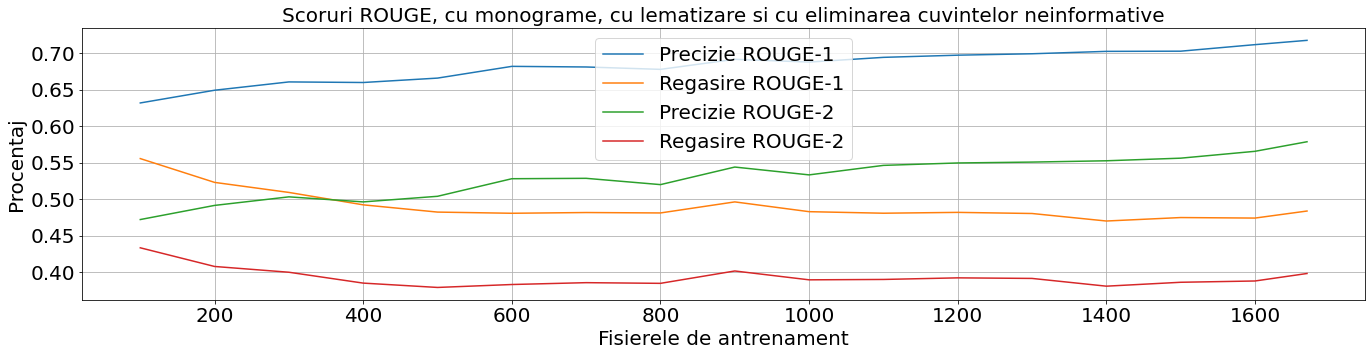

Precizia ROUGE-1 cu monograme, cu lematizare si cu eliminare: 0.7175867278406504
Regasirea ROUGE-1 cu monograme, cu lematizare si cu eliminare: 0.4838641199066445
Precizia ROUGE-2 cu monograme, cu lematizare si cu eliminare: 0.5787345628884892
Regasirea ROUGE-2 cu monograme, cu lematizare si cu eliminare: 0.3983185687233168


In [4]:
train_and_test('BBC News Summary', 'stop_words', True, True, 1)

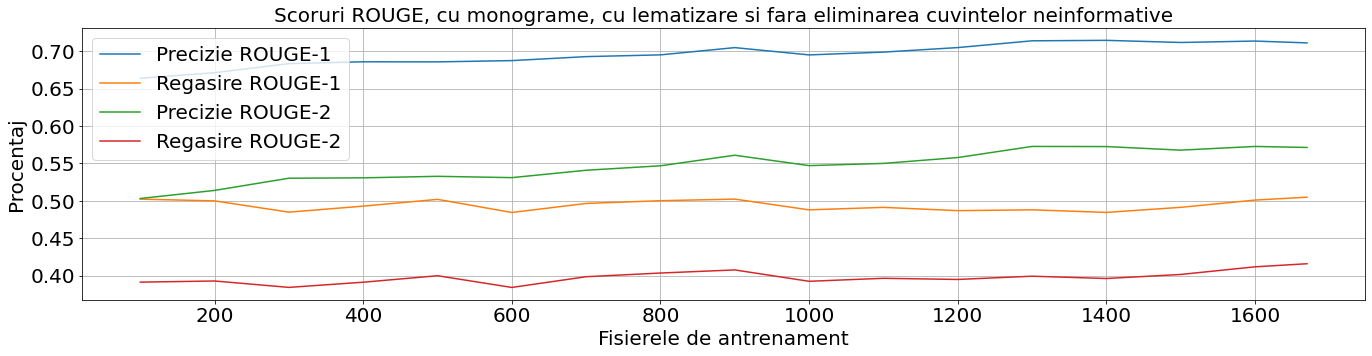

Precizia ROUGE-1 cu monograme, cu lematizare si fara eliminare: 0.7114460345018667
Regasirea ROUGE-1 cu monograme, cu lematizare si fara eliminare: 0.5048854117201513
Precizia ROUGE-2 cu monograme, cu lematizare si fara eliminare: 0.5714561494374282
Regasirea ROUGE-2 cu monograme, cu lematizare si fara eliminare: 0.4157818529340479


In [5]:
train_and_test('BBC News Summary', 'stop_words', False, True, 1)

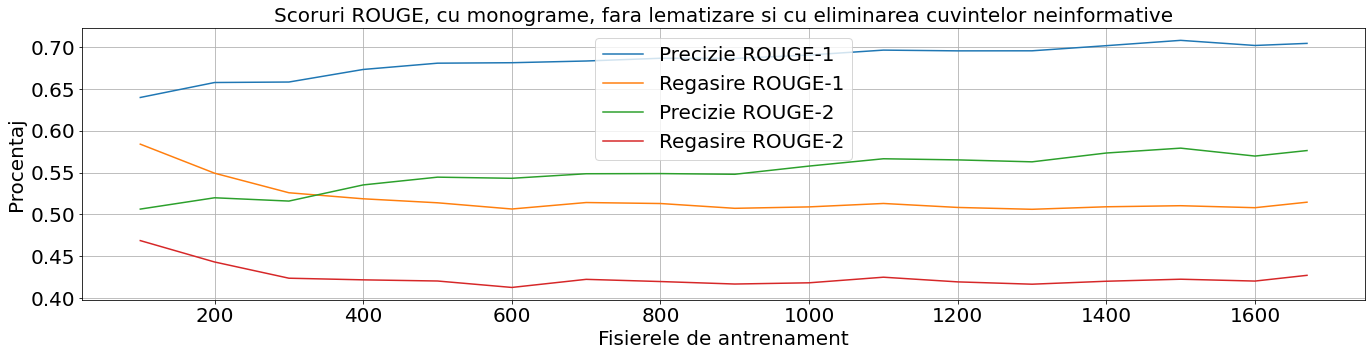

Precizia ROUGE-1 cu monograme, fara lematizare si cu eliminare: 0.7044869316269107
Regasirea ROUGE-1 cu monograme, fara lematizare si cu eliminare: 0.5144850017875757
Precizia ROUGE-2 cu monograme, fara lematizare si cu eliminare: 0.5762645453068362
Regasirea ROUGE-2 cu monograme, fara lematizare si cu eliminare: 0.4269872903541257


In [6]:
train_and_test('BBC News Summary', 'stop_words', True, False, 1)

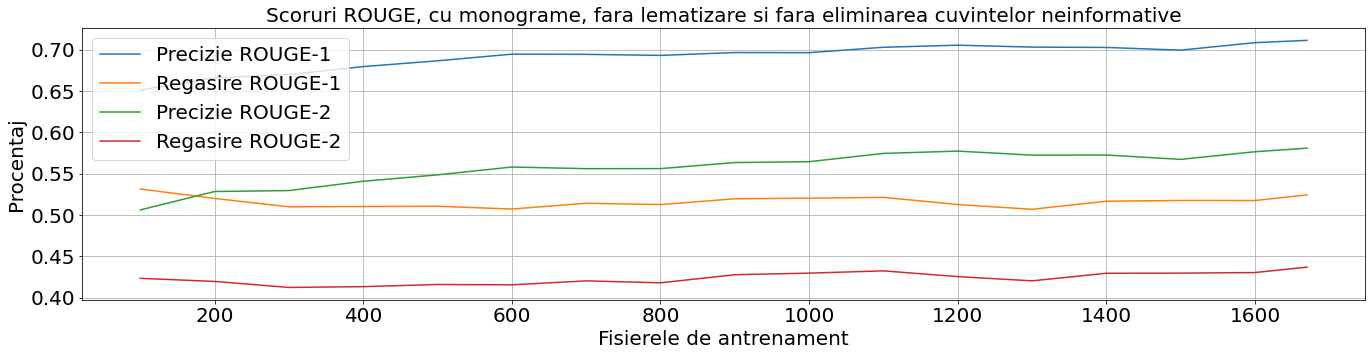

Precizia ROUGE-1 cu monograme, fara lematizare si fara eliminare: 0.7112060035966997
Regasirea ROUGE-1 cu monograme, fara lematizare si fara eliminare: 0.5244011395082805
Precizia ROUGE-2 cu monograme, fara lematizare si fara eliminare: 0.5808740050740179
Regasirea ROUGE-2 cu monograme, fara lematizare si fara eliminare: 0.4370784735852077


In [7]:
train_and_test('BBC News Summary', 'stop_words', False, False, 1)

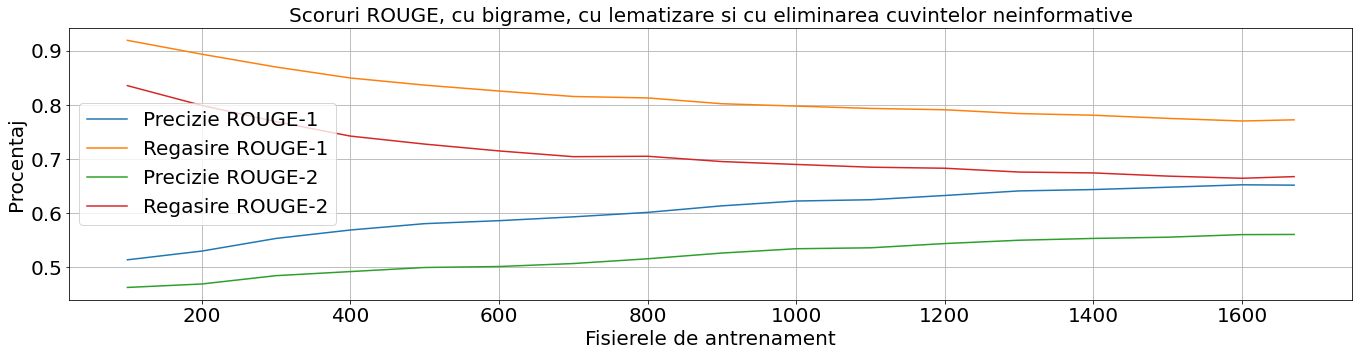

Precizia ROUGE-1 cu bigrame, cu lematizare si cu eliminare: 0.6514123904697972
Regasirea ROUGE-1 cu bigrame, cu lematizare si cu eliminare: 0.7722507908081879
Precizia ROUGE-2 cu bigrame, cu lematizare si cu eliminare: 0.5602361513611489
Regasirea ROUGE-2 cu bigrame, cu lematizare si cu eliminare: 0.6671928252330004


In [8]:
train_and_test('BBC News Summary', 'stop_words', True, True, 2)

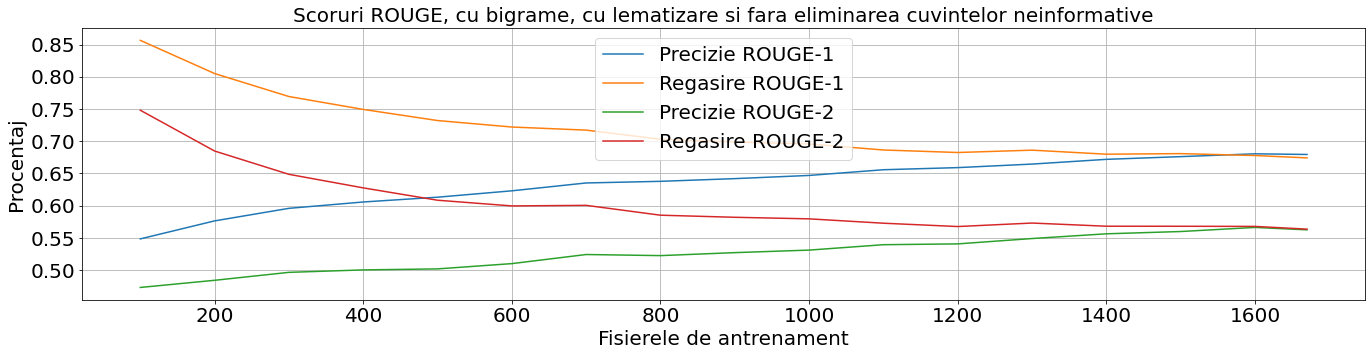

Precizia ROUGE-1 cu bigrame, cu lematizare si fara eliminare: 0.6794614532248524
Regasirea ROUGE-1 cu bigrame, cu lematizare si fara eliminare: 0.6741557348934276
Precizia ROUGE-2 cu bigrame, cu lematizare si fara eliminare: 0.5625032164574081
Regasirea ROUGE-2 cu bigrame, cu lematizare si fara eliminare: 0.5636051698208251


In [9]:
train_and_test('BBC News Summary', 'stop_words', False, True, 2)

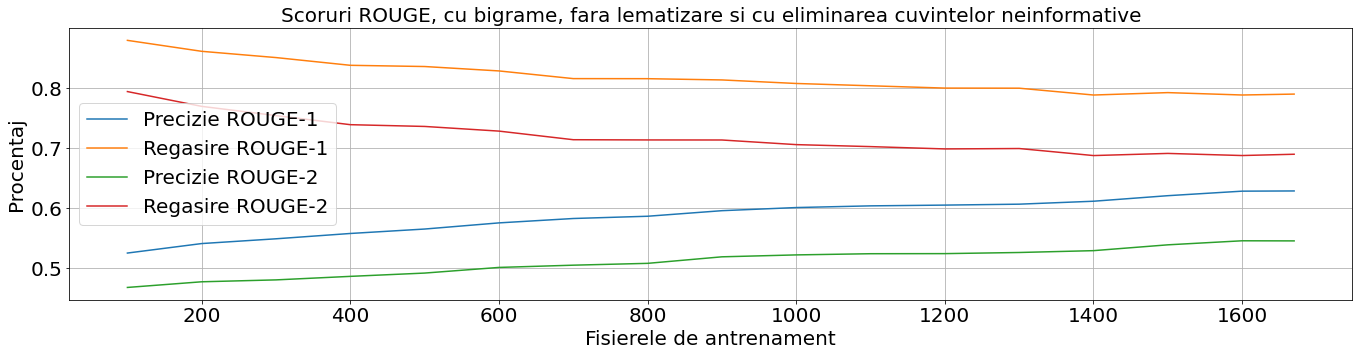

Precizia ROUGE-1 cu bigrame, fara lematizare si cu eliminare: 0.6285289354298559
Regasirea ROUGE-1 cu bigrame, fara lematizare si cu eliminare: 0.7896954947911602
Precizia ROUGE-2 cu bigrame, fara lematizare si cu eliminare: 0.5454265628051413
Regasirea ROUGE-2 cu bigrame, fara lematizare si cu eliminare: 0.6896113453016637


In [10]:
train_and_test('BBC News Summary', 'stop_words', True, False, 2)

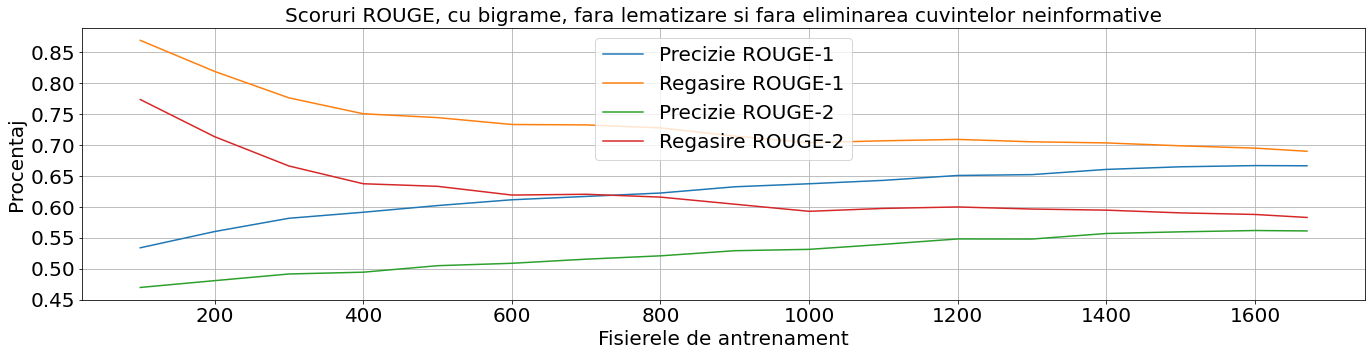

Precizia ROUGE-1 cu bigrame, fara lematizare si fara eliminare: 0.6662599297518441
Regasirea ROUGE-1 cu bigrame, fara lematizare si fara eliminare: 0.6896781050195299
Precizia ROUGE-2 cu bigrame, fara lematizare si fara eliminare: 0.5610636409902667
Regasirea ROUGE-2 cu bigrame, fara lematizare si fara eliminare: 0.5828090896603046


In [11]:
train_and_test('BBC News Summary', 'stop_words', False, False, 2)

In [12]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, True, 1, 5)

Performantele modelului antrenat prin 5-fold cross validation cu monograme, cu lematizare si cu eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.7065359465996227,
            "stddev": 0.006917372955257305
        },
        "recall": {
            "mean": 0.47986442669272783,
            "stddev": 0.009091711804958519
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5619668764567385,
            "stddev": 0.012595981692332303
        },
        "recall": {
            "mean": 0.39086257050315754,
            "stddev": 0.009581630899300675
        }
    }
}


In [13]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, True, 1, 5)

Performantele modelului antrenat prin 5-fold cross validation cu monograme, cu lematizare si fara eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.7149189928832946,
            "stddev": 0.002716793088900146
        },
        "recall": {
            "mean": 0.5034026485269252,
            "stddev": 0.015891601385665748
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5777797471061129,
            "stddev": 0.006263863613871618
        },
        "recall": {
            "mean": 0.41623011973913127,
            "stddev": 0.014607395123024926
        }
    }
}


In [14]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, False, 1, 5)

Performantele modelului antrenat prin 5-fold cross validation cu monograme, fara lematizare si cu eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.7007130571056897,
            "stddev": 0.013812835318279816
        },
        "recall": {
            "mean": 0.5076801985838143,
            "stddev": 0.009870422121232096
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5687403397048634,
            "stddev": 0.019740615206712657
        },
        "recall": {
            "mean": 0.4201888204643283,
            "stddev": 0.012358772831263473
        }
    }
}


In [15]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, False, 1, 5)

Performantele modelului antrenat prin 5-fold cross validation cu monograme, fara lematizare si fara eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.7042920236260637,
            "stddev": 0.0069698940694688715
        },
        "recall": {
            "mean": 0.5216347817407523,
            "stddev": 0.01716861496271103
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5759395141883351,
            "stddev": 0.008734361090951005
        },
        "recall": {
            "mean": 0.43484410903020665,
            "stddev": 0.013740852392755515
        }
    }
}


In [16]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, True, 2, 5)

Performantele modelului antrenat prin 5-fold cross validation cu bigrame, cu lematizare si cu eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.6424321260090241,
            "stddev": 0.003962850154648511
        },
        "recall": {
            "mean": 0.7709148486443828,
            "stddev": 0.007826537986498126
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5479899174412882,
            "stddev": 0.004349003486667344
        },
        "recall": {
            "mean": 0.6606676414111206,
            "stddev": 0.009173408682570059
        }
    }
}


In [17]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, True, 2, 5)

Performantele modelului antrenat prin 5-fold cross validation cu bigrame, cu lematizare si fara eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.6843480840485963,
            "stddev": 0.0066380744396508365
        },
        "recall": {
            "mean": 0.6796231197536917,
            "stddev": 0.008494025974727594
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5693706792961107,
            "stddev": 0.007638282540579883
        },
        "recall": {
            "mean": 0.5711134861044742,
            "stddev": 0.006983381086320104
        }
    }
}


In [18]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, False, 2, 5)

Performantele modelului antrenat prin 5-fold cross validation cu bigrame, fara lematizare si cu eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.6369247275090779,
            "stddev": 0.009032240242702721
        },
        "recall": {
            "mean": 0.7768285687658266,
            "stddev": 0.010678459328671541
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5518253625843534,
            "stddev": 0.008937037463691264
        },
        "recall": {
            "mean": 0.6762915213336621,
            "stddev": 0.011857523075056019
        }
    }
}


In [19]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, False, 2, 5)

Performantele modelului antrenat prin 5-fold cross validation cu bigrame, fara lematizare si fara eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.6711379545637688,
            "stddev": 0.006377668716578898
        },
        "recall": {
            "mean": 0.7010663185197322,
            "stddev": 0.00837199424814987
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5675395772789085,
            "stddev": 0.006205746869609688
        },
        "recall": {
            "mean": 0.5976503596789409,
            "stddev": 0.009919080159222153
        }
    }
}
